In [8]:
pip install xgbse

  Using cached xgbse-0.2.3-py3-none-any.whl (35 kB)
  Using cached xgboost-1.7.1-py3-none-win_amd64.whl (89.1 MB)
  Using cached lifelines-0.27.4-py3-none-any.whl (349 kB)
  Using cached formulaic-0.5.2-py3-none-any.whl (77 kB)
  Using cached autograd_gamma-0.5.0-py3-none-any.whl
  Using cached autograd-1.5-py3-none-any.whl (48 kB)
  Using cached future-0.18.2-py3-none-any.whl
  Using cached graphlib_backport-1.0.3-py3-none-any.whl (5.1 kB)
  Using cached astor-0.8.1-py2.py3-none-any.whl (27 kB)
  Using cached interface_meta-1.3.0-py3-none-any.whl (14 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pycox

     ---------------------------------------- 73.7/73.7 kB 4.2 MB/s eta 0:00:00
     ---------------------------------------- 41.9/41.9 kB 2.1 MB/s eta 0:00:00
     ---------------------------------------- 65.8/65.8 kB ? eta 0:00:00
  Using cached numba-0.56.4-cp38-cp38-win_amd64.whl (2.5 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     --------------------------------------- 20.3/20.3 MB 10.9 MB/s eta 0:00:00
  Using cached llvmlite-0.39.1-cp38-cp38-win_amd64.whl (23.2 MB)
     ------------------------------------- 365.3/365.3 kB 11.5 MB/s eta 0:00:00
     -------------------------------------- 206.5/206.5 kB 6.3 MB/s eta 0:00:00
     ---------------------------------------- 46.1/46.1 kB ? eta 0:00:00
     ---------------------------------------- 1.7/1.7 MB 11.0 MB/s eta 0:00:00
  Created wheel for feather-format: filename=feather_format-0.4.1-py3-none-any.whl size=2442 sha256=f10f8f9b98526b2fc75fcd373f2607c93a16ec60c94b4d8

In [13]:
# basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# models and metrics
import xgboost as xgb
from sklearn.model_selection import train_test_split
from xgbse.metrics import concordance_index
from xgbse.non_parametric import get_time_bins
from xgbse import (
    XGBSEKaplanNeighbors,
    XGBSEKaplanTree,
    XGBSEDebiasedBCE,
    XGBSEBootstrapEstimator
)
from xgbse.converters import (
    convert_data_to_xgb_format,
    convert_to_structured
)

# better plots
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.style.use('bmh')

# setting seed
np.random.seed(42)

C:\Users\kimhongbum\AppData\Local\Temp\ipykernel_19816\3320907469.py:25: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


In [26]:
# to easily plot confidence intervals

def plot_ci(mean, upper_ci, lower_ci, i=42, title='Probability of survival $P(T \geq t)$'):

    # plotting mean and confidence intervals
    plt.figure(figsize=(12, 4), dpi=120)
    plt.plot(mean.columns,mean.iloc[i])
    plt.fill_between(mean.columns, lower_ci.iloc[i], upper_ci.iloc[i], alpha=0.2)

    plt.title(title)
    plt.xlabel('Time [days]')
    plt.ylabel('Probability')
    plt.tight_layout()

In [14]:
# importing dataset from pycox package
from pycox.datasets import metabric

# getting data
df = metabric.read_df()

# splitting to X, T, E format
X = df.drop(['duration', 'event'], axis=1)
y = convert_to_structured(df['duration'], df['event'])

# splitting between train, and validation
(X_train, X_valid,
 y_train, y_valid) = \
train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
PARAMS_XGB_AFT = {
    'objective': 'survival:aft',
    'eval_metric': 'aft-nloglik',
    'aft_loss_distribution': 'normal',
    'aft_loss_distribution_scale': 1.0,
    'tree_method': 'hist',
    'learning_rate': 5e-2,
    'max_depth': 8,
    'booster':'dart',
    'subsample':0.5,
    'min_child_weight': 50,
    'colsample_bynode':0.5
}
# 실험읋 위한 하이퍼 파라미터 설정
PARAMS_XGB_COX = {
    'objective': 'survival:cox',
    'tree_method': 'hist',
    'learning_rate': 5e-2,
    'max_depth': 8,
    'booster':'dart',
    'subsample':0.5,
    'min_child_weight': 50,
    'colsample_bynode':0.5
}

PARAMS_TREE = {
    'objective': 'survival:cox',
    'eval_metric': 'cox-nloglik',
    'tree_method': 'hist',
    'max_depth': 100,
    'booster':'dart',
    'subsample': 1.0,
    'min_child_weight': 50,
}

PARAMS_LR = {
    'C': 1e-3,
    'max_iter': 500
}

N_NEIGHBORS = 50

TIME_BINS = np.arange(15, 315, 15)

In [16]:
dtrain = convert_data_to_xgb_format(X_train, y_train, 'survival:aft')
dval = convert_data_to_xgb_format(X_valid, y_valid, 'survival:aft')

# training model
bst = xgb.train(
    PARAMS_XGB_AFT,
    dtrain,
    num_boost_round=1000,
    early_stopping_rounds=10,
    evals=[(dval, 'val')],
    verbose_eval=0
)

# predicting and evaluating
preds = bst.predict(dval)
cind = concordance_index(y_valid, -preds, risk_strategy='precomputed')

In [24]:
# saving predictions to plot later
preds_dict = {}

# loop to show different scale results
for scale in [1.5, 1.0, 0.5]:

    # chaning parameter
    PARAMS_XGB_AFT['aft_loss_distribution_scale'] = scale

    # training model
    bst = xgb.train(
        PARAMS_XGB_AFT,
        dtrain,
        num_boost_round=1000,
        early_stopping_rounds=10,
        evals=[(dval, 'val')],
        verbose_eval=0
    )

    # predicting and evaluating
    preds = bst.predict(dval)
    cind = concordance_index(y_valid, -preds, risk_strategy='precomputed')

    preds_dict[scale] = preds

    print(f"aft_loss_distribution_scale: {scale}")
    print(f"C-index: {cind:.3f}")
    print(f"Average survival time: {preds.mean():.0f} days")
    print("----")

aft_loss_distribution_scale: 1.5
C-index: 0.643
Average survival time: 201 days
----
aft_loss_distribution_scale: 1.0
C-index: 0.651
Average survival time: 159 days
----
aft_loss_distribution_scale: 0.5
C-index: 0.643
Average survival time: 128 days
----


## 성능 검증

In [20]:
# importing xgbse
from xgbse import XGBSEKaplanNeighbors
from xgbse._kaplan_neighbors import DEFAULT_PARAMS
from xgbse.metrics import concordance_index


# loop to show different scale results
for scale in [1.5, 1.0, 0.5]:

    # chaning parameter
    DEFAULT_PARAMS['aft_loss_distribution_scale'] = scale

    # training model
    xgbse_model = XGBSEKaplanNeighbors(DEFAULT_PARAMS, n_neighbors=30)
    xgbse_model.fit(
        X_train, y_train,
        validation_data = (X_valid, y_valid),
        early_stopping_rounds=10,
        time_bins=TIME_BINS
    )

    # predicting and evaluating
    preds = xgbse_model.predict(X_valid)
    cind = concordance_index(y_valid, preds)
    avg_probs = preds[[30, 90, 150]].mean().values.round(4).tolist()

    print(f"aft_loss_distribution_scale: {scale}")
    print(f"C-index: {cind:.3f}")
    print(f"Average probability of survival at [30, 90, 150] days: {avg_probs}")
    print("----")

aft_loss_distribution_scale: 1.5
C-index: 0.625
Average probability of survival at [30, 90, 150] days: [0.9085, 0.6855, 0.5289]
----
aft_loss_distribution_scale: 1.0
C-index: 0.646
Average probability of survival at [30, 90, 150] days: [0.9092, 0.6831, 0.5287]
----
aft_loss_distribution_scale: 0.5
C-index: 0.648
Average probability of survival at [30, 90, 150] days: [0.918, 0.6971, 0.5321]
----


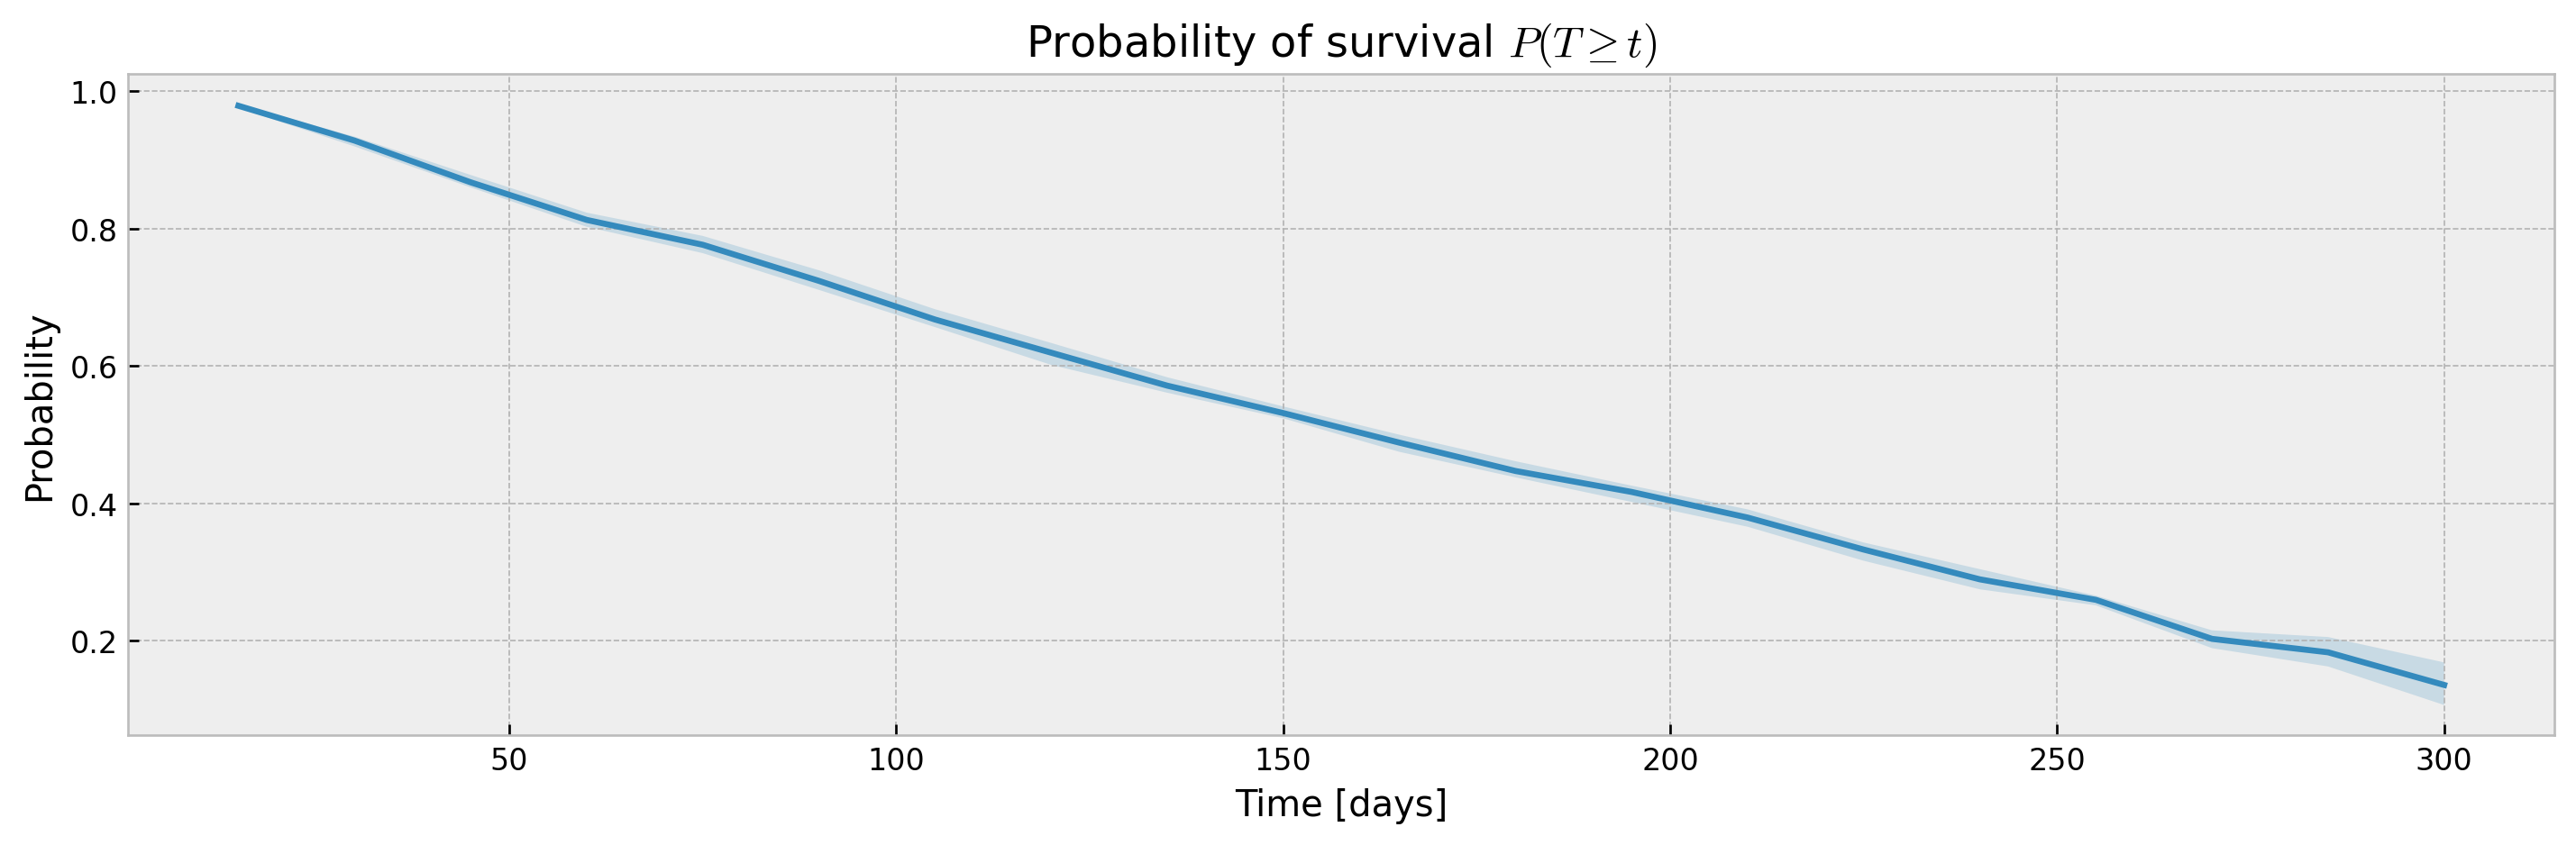

In [27]:
# base model as BCE
base_model = XGBSEDebiasedBCE(PARAMS_XGB_AFT, PARAMS_LR)

# bootstrap meta estimator
bootstrap_estimator = XGBSEBootstrapEstimator(base_model, n_estimators=20)

# fitting the meta estimator
bootstrap_estimator.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    early_stopping_rounds=10,
    time_bins=TIME_BINS,
)

# predicting
mean, upper_ci, lower_ci = bootstrap_estimator.predict(X_valid, return_ci=True)

# plotting CIs
plot_ci(mean, upper_ci, lower_ci)

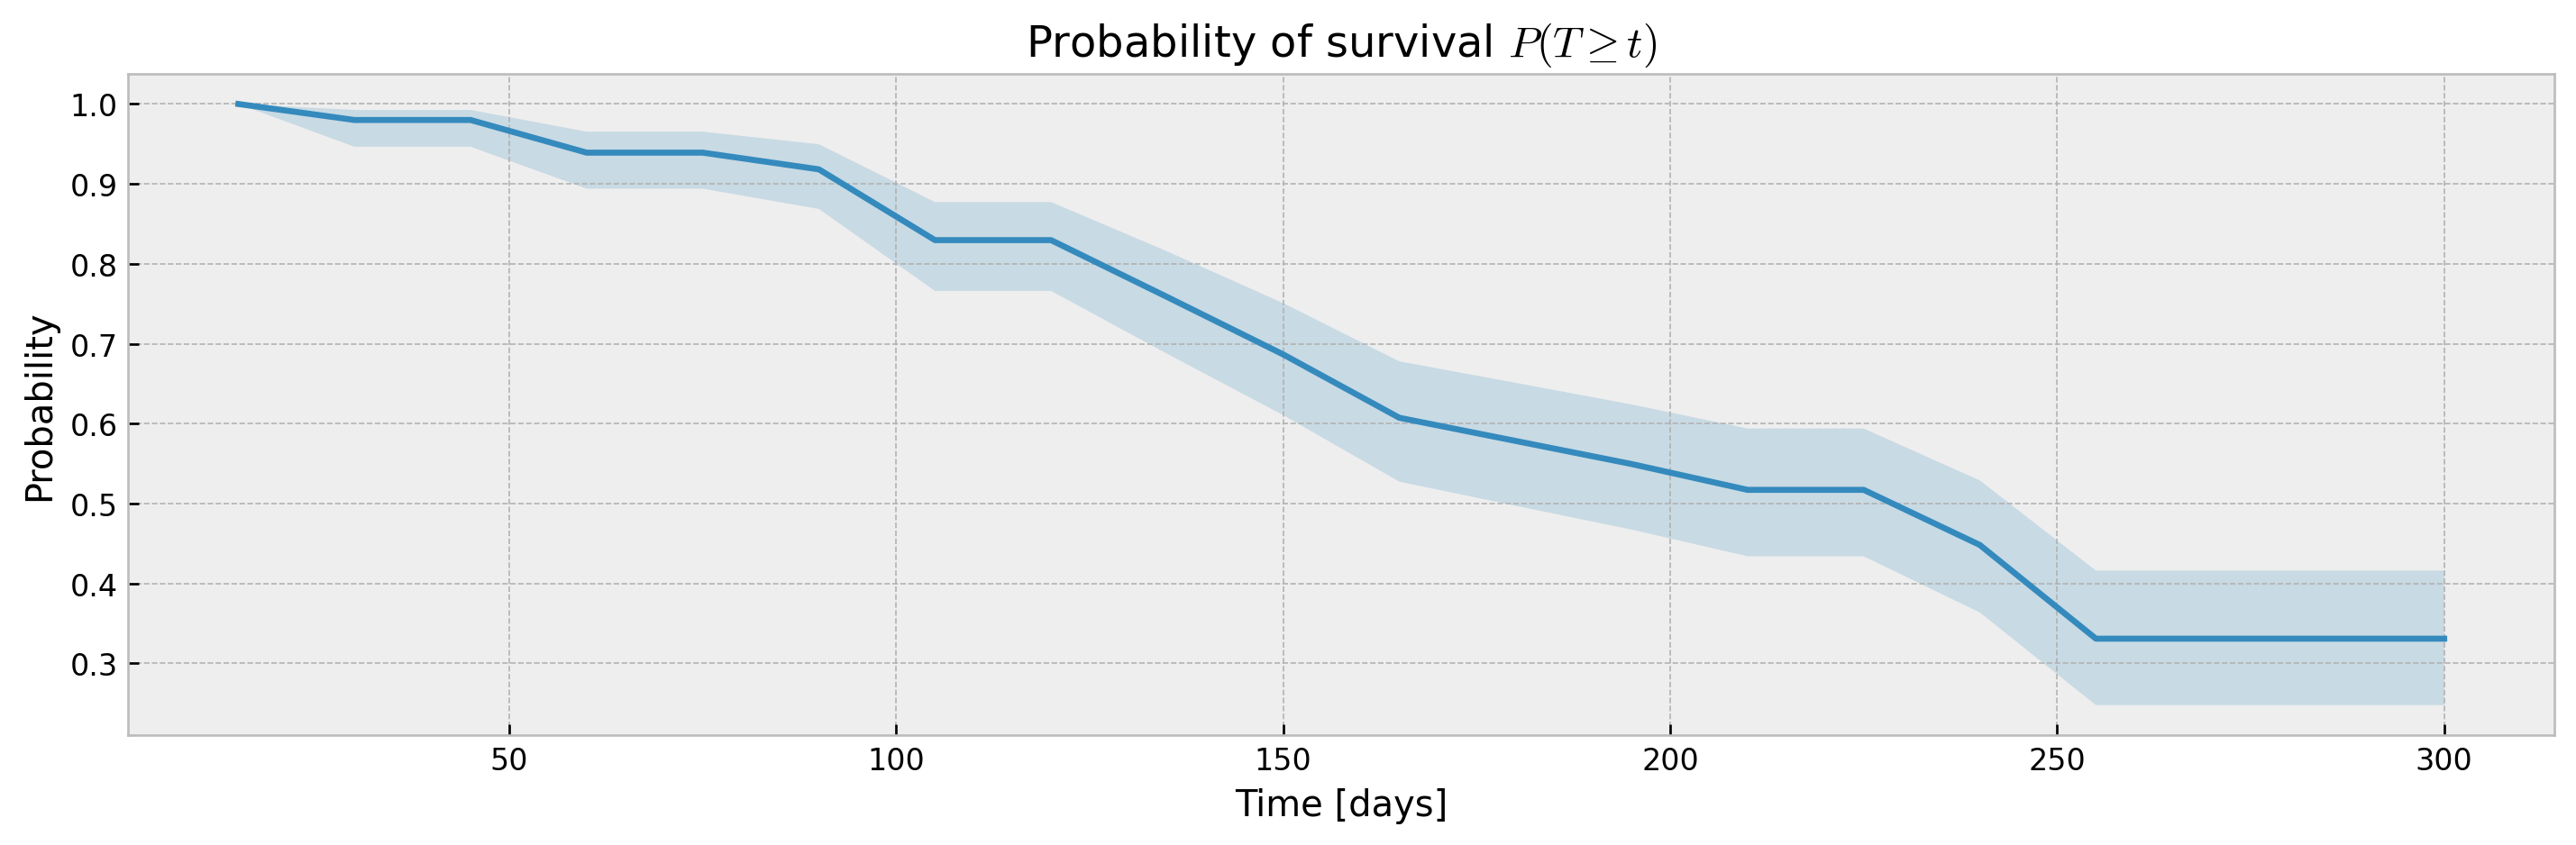

In [28]:
# fitting xgbse model
xgbse_model = XGBSEKaplanNeighbors(n_neighbors=50)
xgbse_model.fit(X_train, y_train, time_bins=TIME_BINS)

# predicting
mean, upper_ci, lower_ci = xgbse_model.predict(X_valid, return_ci=True)

# plotting CIs
plot_ci(mean, upper_ci, lower_ci)

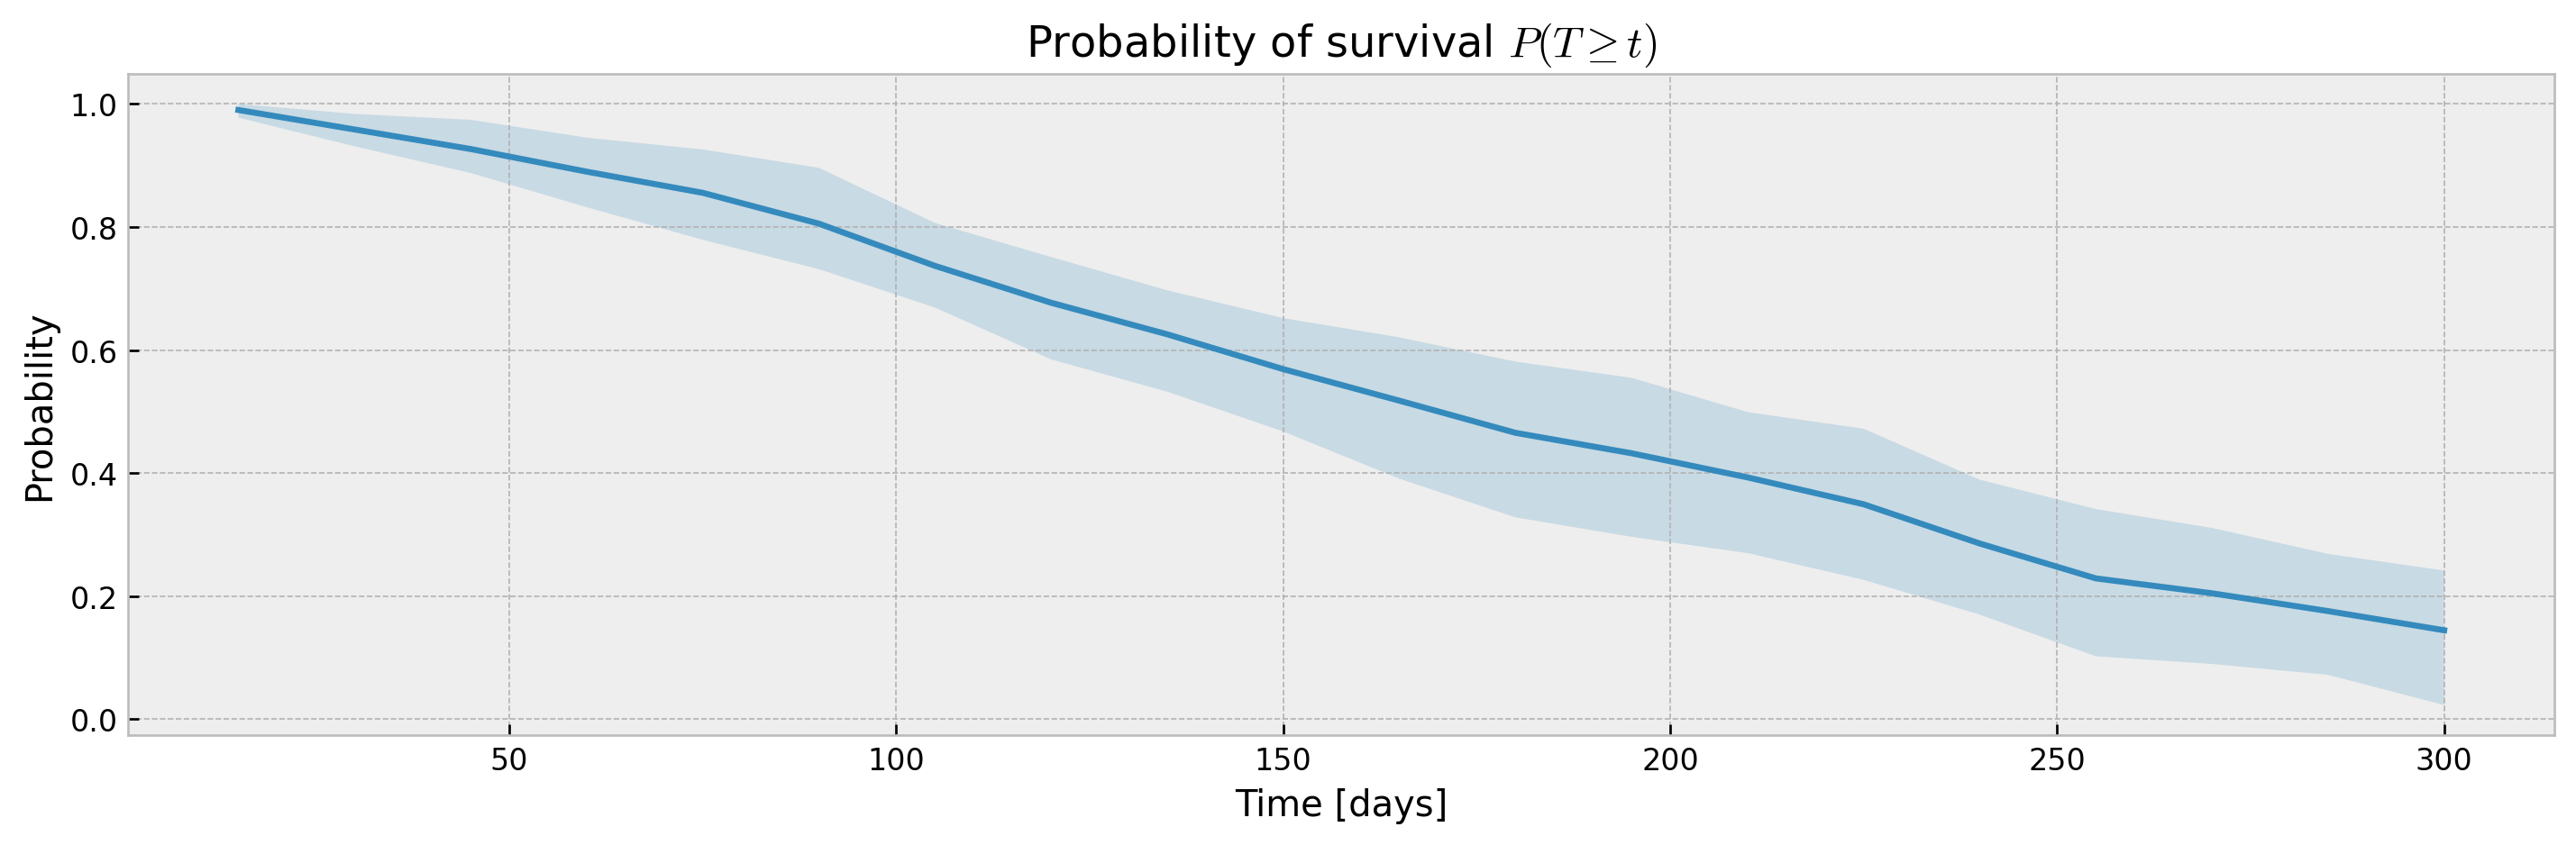

In [29]:
# base model
base_model = XGBSEKaplanTree(PARAMS_TREE)

# bootstrap meta estimator
bootstrap_estimator = XGBSEBootstrapEstimator(base_model, n_estimators=100)

# fitting the meta estimator
bootstrap_estimator.fit(
    X_train,
    y_train,
    time_bins=TIME_BINS,
)

# predicting
mean, upper_ci, lower_ci = bootstrap_estimator.predict(X_valid, return_ci=True)

# plotting CIs
plot_ci(mean, upper_ci, lower_ci)